<a href="https://colab.research.google.com/github/TianYubo/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 从零开始构建扩散模型

有时考虑某个事物的最简单版本有助于更好地理解其工作原理。在本笔记本中，我们将尝试这样做，首先从一个“玩具”扩散模型开始，了解各个部分是如何工作的，然后分析它们与更复杂实现之间的差异。

我们将研究以下内容：
- 腐蚀过程（向数据添加噪声）
- UNet 是什么，以及如何从零开始实现一个极其简化的 UNet
- 扩散模型训练
- 采样理论

然后我们将把我们的版本与 diffusers 的 DDPM 实现进行比较，探讨以下内容：
- 对我们简化版 UNet 的改进
- DDPM 噪声调度
- 训练目标的差异
- 时间步长条件
- 采样方法

本笔记本内容较为深入，如果你对从零开始的深度探索不感兴趣，可以安全跳过！

还值得一提的是，这里的大部分代码仅用于说明目的，我并不建议直接将其应用于你自己的工作中（除非你只是为了学习目的改进这些示例）。

## 设置与导入:

In [1]:
%pip install -q diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## 数据

在这里，我们将使用一个非常小的数据集：mnist 进行测试。如果你想给模型增加一点难度，而又不改变其他任何内容，torchvision.datasets.FashionMNIST 可以作为一个直接替代品。

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.81MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.61MB/s]


In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([4, 5, 1, 0, 7, 2, 1, 4])


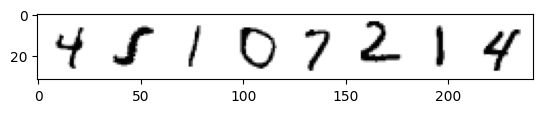

In [5]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

每张图像都是一个灰度 28px x 28px 的数字绘图，数值范围从 0 到 1。

## 腐蚀过程

假设你没有读过任何扩散模型的论文，但你知道该过程涉及添加噪声。你会怎么做？

我们可能需要一种简单的方式来控制腐蚀的程度。那么，如果我们接受一个参数来表示要添加的`噪声量`，然后我们这样做：

`noise = torch.rand_like(x)`

`noisy_x =  (1-amount)*x + amount*noise`

如果 amount = 0，我们将得到完全未改变的输入。如果 amount 达到 1，我们将得到完全没有输入 x 痕迹的噪声。通过这种方式将输入与噪声混合，我们可以使输出保持在相同的范围（0 到 1）。

我们可以相对容易地实现这一点（只需注意形状，以免被广播规则所困扰）：

In [6]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

并从视觉上查看结果以确认它按预期工作：

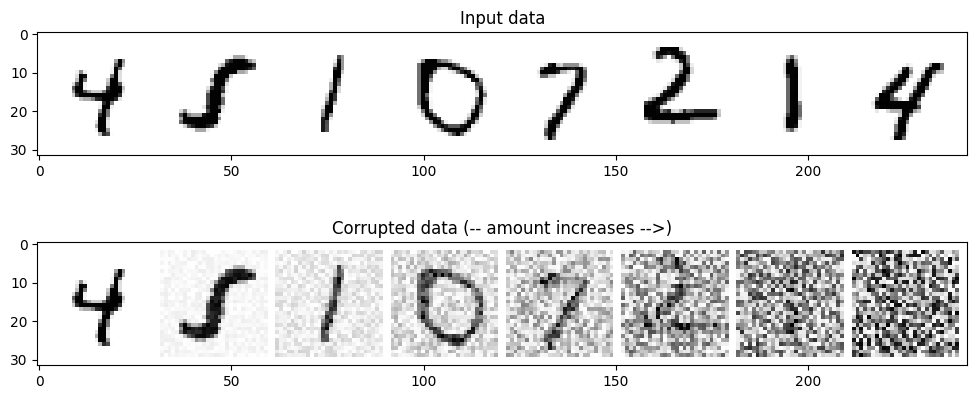

In [7]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

当噪声量接近一时，我们的数据开始看起来像纯随机噪声。但是，对于大多数噪声量，你仍然可以相当好地猜出数字。你认为这是最优的吗？

## 模型

我们希望构建一个模型，它能够接收28像素的噪声图像，并输出相同形状的预测结果。这里一个流行的选择是叫做UNet的架构。[最初是为了医学影像中的分割任务而发明](https://arxiv.org/abs/1505.04597)，UNet 包含一个“收缩路径”，通过该路径数据被压缩，以及一个“扩展路径”，通过该路径数据再恢复到原始维度（类似于自编码器），但它还具有跳跃连接（skip connections），允许信息和梯度在不同层次之间流动。

一些 UNet 在每个阶段包含复杂的模块，但在这个简单的演示中，我们将构建一个最小化的例子：接收单通道图像，并通过三个下采样路径上的卷积层（图和代码中的 down_layers）和三个上采样路径上的卷积层，同时在下采样层和上采样层之间加入跳跃连接。我们将使用最大池化进行下采样，并使用 `nn.Upsample` 进行上采样，而不是依赖更复杂的 UNet 中那种可学习的层。以下是大致的架构，显示了每一层输出的通道数：

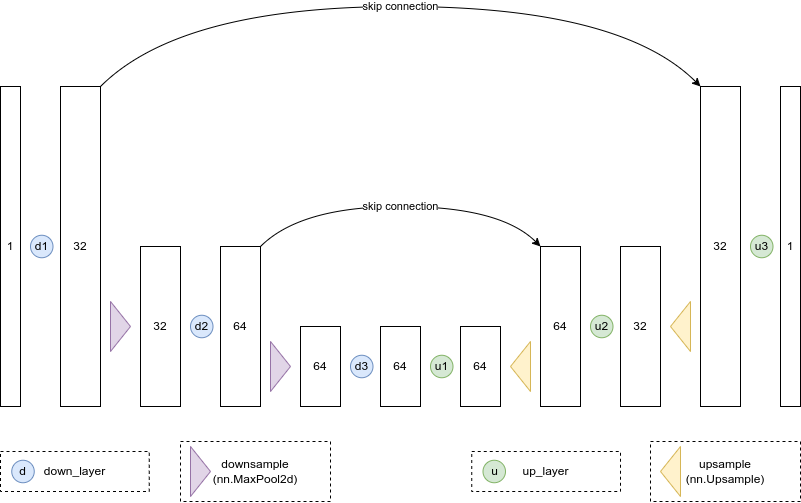

这就是它在代码中的样子:

In [8]:
class BasicUNet(nn.Module):
    """
    一个简化版的UNet实现。
    UNet是一种编码器-解码器架构，具有跳跃连接，常用于图像分割和生成任务。
    """
    def __init__(self, in_channels=1, out_channels=1):
        """
        初始化UNet模型。

        参数:
            in_channels (int): 输入图像的通道数，默认为1（灰度图像）
            out_channels (int): 输出图像的通道数，默认为1
        """
        super().__init__()

        # 下采样路径（编码器）的卷积层
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),  # 第一层：输入通道 -> 32通道
            nn.Conv2d(32, 64, kernel_size=5, padding=2),           # 第二层：32通道 -> 64通道
            nn.Conv2d(64, 64, kernel_size=5, padding=2),           # 第三层：64通道 -> 64通道
        ])

        # 上采样路径（解码器）的卷积层
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),           # 第一层：64通道 -> 64通道
            nn.Conv2d(64, 32, kernel_size=5, padding=2),           # 第二层：64通道 -> 32通道
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), # 第三层：32通道 -> 输出通道
        ])

        # 激活函数：SiLU (Sigmoid Linear Unit)，也称为Swish
        self.act = nn.SiLU()

        # 下采样操作：使用2x2最大池化将特征图尺寸减半
        self.downscale = nn.MaxPool2d(2)

        # 上采样操作：将特征图尺寸扩大一倍
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        """
        前向传播函数。

        参数:
            x: 输入张量 [batch_size, in_channels, height, width]

        返回:
            输出张量 [batch_size, out_channels, height, width]
        """
        # 用于存储跳跃连接的特征图
        h = []

        # 下采样路径（编码器）
        for i, layer in enumerate(self.down_layers):
            # 通过卷积层和激活函数处理
            x = self.act(layer(x))

            # 对于前两层（索引0和1）
            if i < 2:
                # 存储当前特征图用于后续的跳跃连接
                h.append(x)
                # 通过最大池化进行下采样，特征图尺寸减半
                x = self.downscale(x)

        # 上采样路径（解码器）
        for i, layer in enumerate(self.up_layers):
            # 对于第二层和第三层（索引1和2）
            if i > 0:
                # 先进行上采样，特征图尺寸扩大一倍
                x = self.upscale(x)
                # 添加跳跃连接（从编码器保存的特征图）
                # pop()方法会移除并返回列表的最后一个元素
                x += h.pop()

            # 通过卷积层和激活函数处理
            x = self.act(layer(x))

        return x


我们可以验证输出形状与输入形状相同，这符合我们的预期：

In [9]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

这个网络有超过300,000个参数:

In [10]:
sum([p.numel() for p in net.parameters()])

309057

如果你想要，可以探索更改每层中的通道数量或交换不同的架构。

## 训练网络

那么模型到底应该做什么呢？同样，对此有不同的看法。但在本演示中，让我们选择一个简单的框架：给定一个被破坏的输入 noisy_x，模型应输出其对原始 x 的最佳猜测。我们将通过均方误差将其与实际值进行比较。

我们现在可以尝试训练网络。
- 获取一批数据
- 通过随机量对其进行破坏
- 将其输入到模型中
- 将模型预测结果与干净图像进行比较以计算我们的损失
- 据此更新模型的参数。

随时可以对其进行修改，并查看是否能让它表现得更好！

完成第0轮训练。本轮平均损失: 0.027113
完成第1轮训练。本轮平均损失: 0.020584
完成第2轮训练。本轮平均损失: 0.018641


(0.0, 0.1)

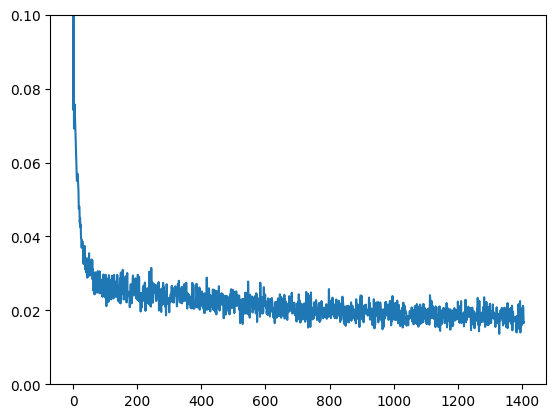

In [11]:
# 数据加载器设置
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # shuffle=True确保每个epoch数据顺序随机

# 训练轮数设置
n_epochs = 3  # 整个数据集将被遍历3次

# 创建UNet网络实例
net = BasicUNet()  # 实例化我们之前定义的UNet模型
net.to(device)  # 将模型移至GPU或CPU设备上

# 定义损失函数
loss_fn = nn.MSELoss()  # 均方误差损失，适用于去噪任务

# 定义优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3)  # Adam优化器，学习率为0.001

# 创建列表记录训练过程中的损失值，用于后续分析和可视化
losses = []

# 训练循环
for epoch in range(n_epochs):  # 外循环：遍历每个训练轮次

    for x, y in train_dataloader:  # 内循环：遍历数据批次

        # 准备输入数据
        x = x.to(device)  # 将输入数据移至指定设备（GPU/CPU）
        noise_amount = torch.rand(x.shape[0]).to(device)  # 为每个样本随机生成噪声量
        # print(f"添加噪音量: {noise_amount}")
        noisy_x = corrupt(x, noise_amount)  # 使用corrupt函数向原始图像添加噪声

        # 前向传播
        pred = net(noisy_x)  # 将噪声图像输入网络，获取预测（去噪后的图像）

        # 计算损失
        loss = loss_fn(pred, x)  # 计算预测图像与原始干净图像之间的MSE损失

        # 反向传播与参数更新
        opt.zero_grad()  # 清除之前的梯度
        loss.backward()  # 计算梯度
        opt.step()  # 更新模型参数

        # 记录当前批次的损失值
        losses.append(loss.item())

    # 每个epoch结束后，计算并打印该epoch的平均损失
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)  # 计算最近一个epoch的平均损失
    print(f'完成第{epoch}轮训练。本轮平均损失: {avg_loss:05f}')

# 可视化训练过程中的损失变化
plt.plot(losses)  # 绘制损失曲线
plt.ylim(0, 0.1)  # 设置y轴范围为0-0.1，便于观察


我们可以通过获取一批数据，用不同程度破坏它，然后查看模型的预测结果，来尝试了解模型的预测情况：

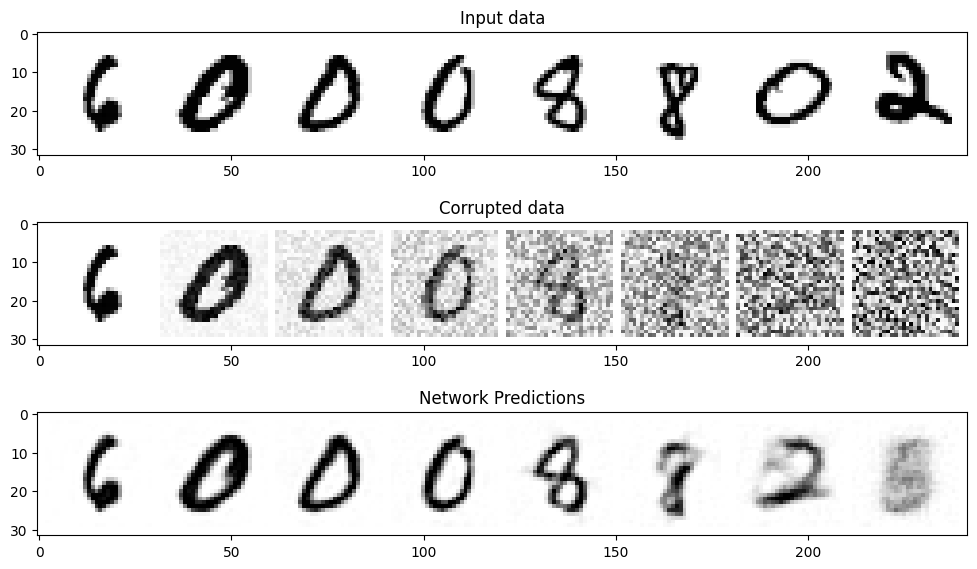

In [12]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

你可以看到，对于较低的数值，预测结果相当不错！但是，当数值变得非常高时，模型可利用的信息就变少了，等到数值达到 amount=1 时，它输出了一个接近数据集均值的模糊结果，试图对其输出可能的样子进行押注对冲...

## 采样

如果我们在高噪声水平下的预测不够好，我们如何生成图像？

那么，如果我们从随机噪声开始，查看模型的预测结果，但只向该预测方向移动一小部分——比如，只移动到那里的20%。现在我们得到了一个非常嘈杂的图像，其中可能有结构的一点线索，我们可以将其输入模型以获得新的预测。我们的期望是这个新预测比第一个预测稍微好一些（因为我们的起点稍微不那么嘈杂），因此我们可以根据这个新的、更好的预测再迈出一小步。

重复几次并且（如果一切顺利）我们就能得到一张图像！以下是仅通过5个步骤展示该过程的示例，可视化了每个阶段的模型输入（左侧）和预测的去噪图像（右侧）。请注意，即使在第1步时模型预测了去噪图像，我们也只移动到那里的x部分。经过几步后，结构逐渐显现并被细化，直到我们得到最终输出。

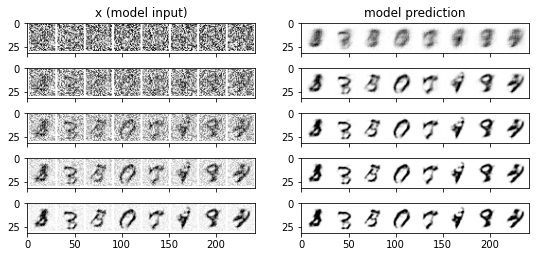

In [ ]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

我们可以将这个过程分成更多的步骤，并且希望这样能得到更好的图像：

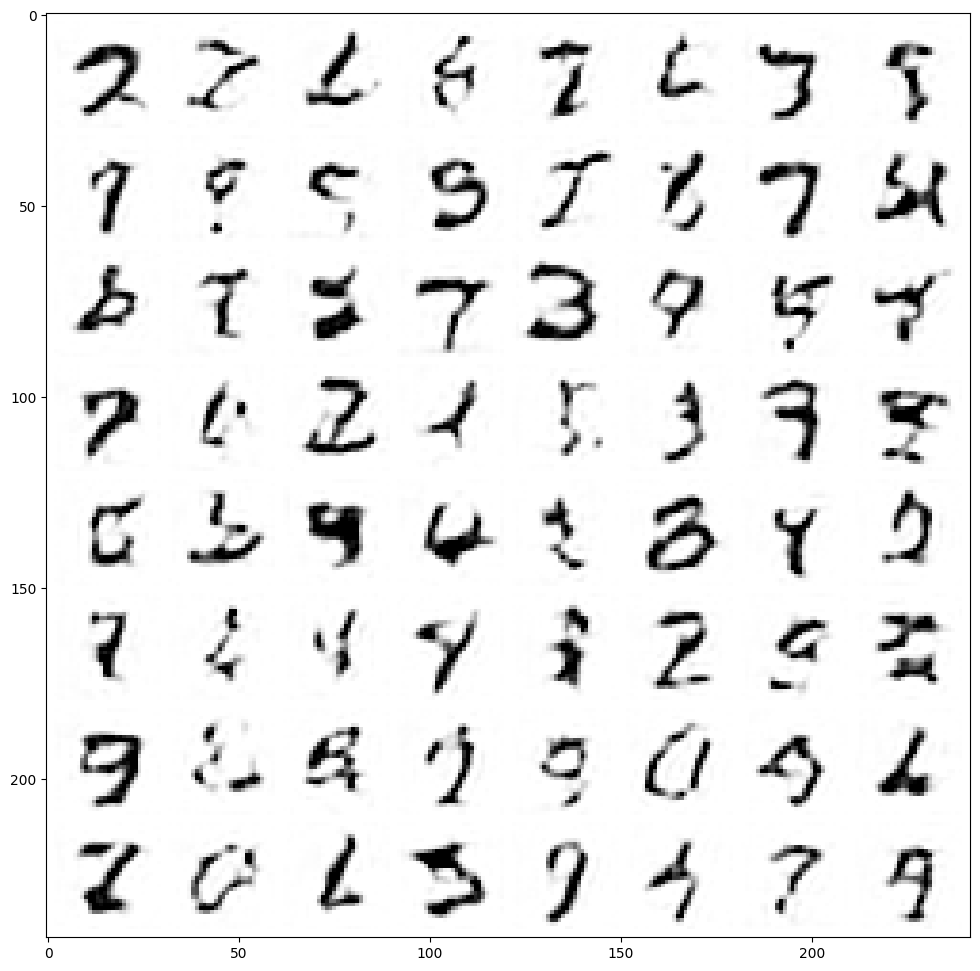

In [13]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

不是很好，但有一些可辨认的数字！你可以尝试训练更长时间（例如，10或20个epoch），并调整模型配置、学习率、优化器等。另外，别忘了如果想尝试一个稍微难一点的数据集，fashionMNIST 只需一行代码就能替换掉当前数据集。

## 与DDPM的比较

在本节中，我们将看看我们的玩具实现与另一份笔记本中的方法有何不同 ([Diffusers简介](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb))，后者是基于DDPM论文的。

我们会发现：


*   Diffusers的 `UNet2DModel` 比我们的BasicUNet稍微复杂一些
*   腐蚀过程的处理方式有所不同
*   训练目标不同，涉及预测噪声而非去噪后的图像
*   模型通过时间步条件来调节噪声量，其中 t 作为额外参数传递给 forward 方法。
*   有多种不同的采样策略可供选择，这些策略应该比我们上面的简单版本表现更好。

自从DDPM论文发布以来，已经提出了许多改进意见，但这个例子希望能有助于说明可用的不同设计决策。读完本节后，你可能会喜欢深入研究论文 ['阐明基于扩散的生成模型的设计空间'](https://arxiv.org/abs/2206.00364)，该论文详细探讨了所有这些组件，并对如何获得最佳性能提出了新的建议。

如果这一切都过于技术化或令人生畏，别担心！随时跳过本笔记本的其余部分，或者留到以后再看。

### UNet

Diffusers 中的 UNet2DModel 模型相较于我们上面的基本 UNet 有以下改进：

*   GroupNorm 对每个块的输入应用组归一化
*   Dropout 层用于更平滑的训练
*   每个块中有多个 ResNet 层（如果 layers_per_block 不设置为 1）
*   注意力机制（通常仅在低分辨率块中使用）
*   对时间步长的条件控制
*   具有可学习参数的下采样和上采样块

让我们创建并检查一个 UNet2DModel：

In [14]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

正如你所见，有更多的内容！它的参数量也比我们的 BasicUNet 多得多：

In [15]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

我们可以使用此模型代替原始模型来复制上述训练过程。我们需要将 x 和 timestep 同时传递给模型（在这里我总是传递 t=0，以显示即使没有这个 timestep 的条件也能正常工作，并且保持采样代码的简单性，但你也可以尝试输入 `(amount*1000)` 来从 corruption amount 获取等效的 timestep）。如果想检查代码，更改的行会用 `#<<<` 标注出来。

完成第0轮训练。本轮平均损失: 0.019461
完成第1轮训练。本轮平均损失: 0.012709
完成第2轮训练。本轮平均损失: 0.011612


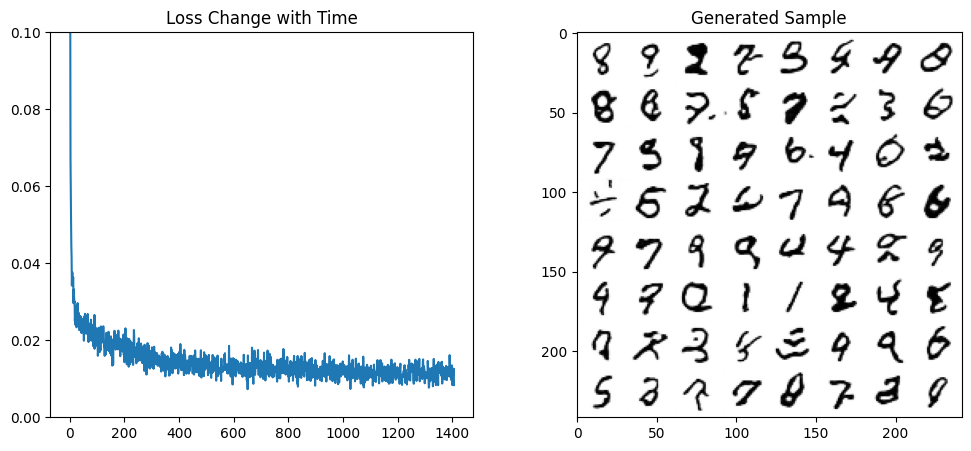

In [17]:
#@markdown 尝试使用UNet2DModel替代BasicUNet:

# 数据加载器（您可以调整批次大小）
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 我们应该对数据进行多少轮训练？
n_epochs = 3

# 创建网络模型
net = UNet2DModel(
    sample_size=28,  # 目标图像分辨率
    in_channels=1,   # 输入通道数，RGB图像为3
    out_channels=1,  # 输出通道数
    layers_per_block=2,  # 每个UNet块使用的ResNet层数
    block_out_channels=(32, 64, 64),  # 大致匹配我们的基本unet示例
    down_block_types=(
        "DownBlock2D",  # 常规ResNet下采样块
        "AttnDownBlock2D",  # 带空间自注意力的ResNet下采样块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # 带空间自注意力的ResNet上采样块
        "UpBlock2D",      # 常规ResNet上采样块
      ),
) #<<<
net.to(device)

# 我们的损失函数
loss_fn = nn.MSELoss()

# 优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# 记录损失值以便后续查看
losses = []

# 训练循环
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # 获取数据并准备加噪版本
        x = x.to(device) # 数据放到GPU上
        noise_amount = torch.rand(x.shape[0]).to(device) # 随机选择噪声量
        noisy_x = corrupt(x, noise_amount) # 创建带噪声的x

        # 获取模型预测
        pred = net(noisy_x, 0).sample #<<< 始终使用时间步0，并添加.sample

        # 计算损失
        loss = loss_fn(pred, x) # 输出与真实"干净"x的接近程度

        # 反向传播并更新参数:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 存储损失值以便后续使用
        losses.append(loss.item())

    # 打印本轮训练的平均损失值:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'完成第{epoch}轮训练。本轮平均损失: {avg_loss:05f}')

# 绘制损失曲线和一些样本
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 损失曲线
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss Change with Time')

# 生成样本
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # 从高到低递减
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Sample');

这看起来比我们第一组结果要好得多！你可以探索调整 unet 配置或延长训练时间以获得更好的性能。

### 腐蚀过程

DDPM 论文描述了一种腐蚀过程，该过程在每个 'timestep' 添加少量的噪声。给定某个时间步的 $x_{t-1}$，我们可以通过以下公式得到下一个（稍微更 noisy）版本 $x_t$：<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


也就是说，我们取 $x_{t-1}$，将其缩放 $\sqrt{1 - \beta_t}$ 倍，并添加按 $\beta_t$ 缩放的噪声。这个 $\beta$ 根据某个调度表为每个 t 定义，并决定了每个时间步添加多少噪声。现在，我们不一定想执行 500 次操作来获得 $x_{500}$，因此我们有另一个公式可以在给定 $x_0$ 的情况下获取任意 t 的 $x_t$：<br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ 其中 $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ 且 $\alpha_i = 1-\beta_i$<br><br>

数学符号总是看起来很吓人！幸运的是，调度器会为我们处理所有这些（取消下一行注释以查看代码）。我们可以绘制 $\sqrt{\bar{\alpha}_t}$（标记为 `sqrt_alpha_prod`）和 $\sqrt{(1 - \bar{\alpha}_t)}$（标记为 `sqrt_one_minus_alpha_prod`），以观察输入 (x) 和噪声在不同时间步如何被缩放和混合：

In [ ]:
#??noise_scheduler.add_noise

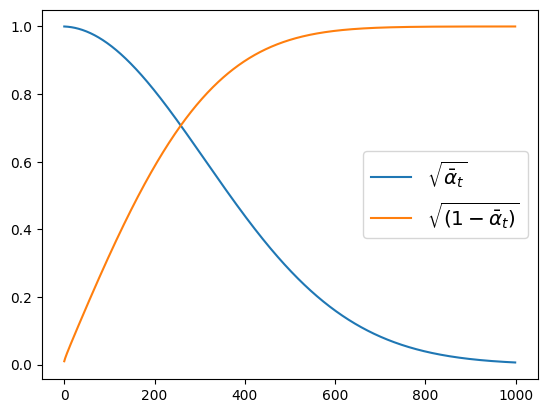

In [18]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

最初，带噪声的 x 主要是 x（sqrt_alpha_prod ~= 1），但随着时间推移，x 的贡献下降，噪声成分增加。与我们根据 `amount` 线性混合 x 和噪声不同，这种模式会相对快速地变得嘈杂。我们可以在一些数据上可视化这一过程：

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


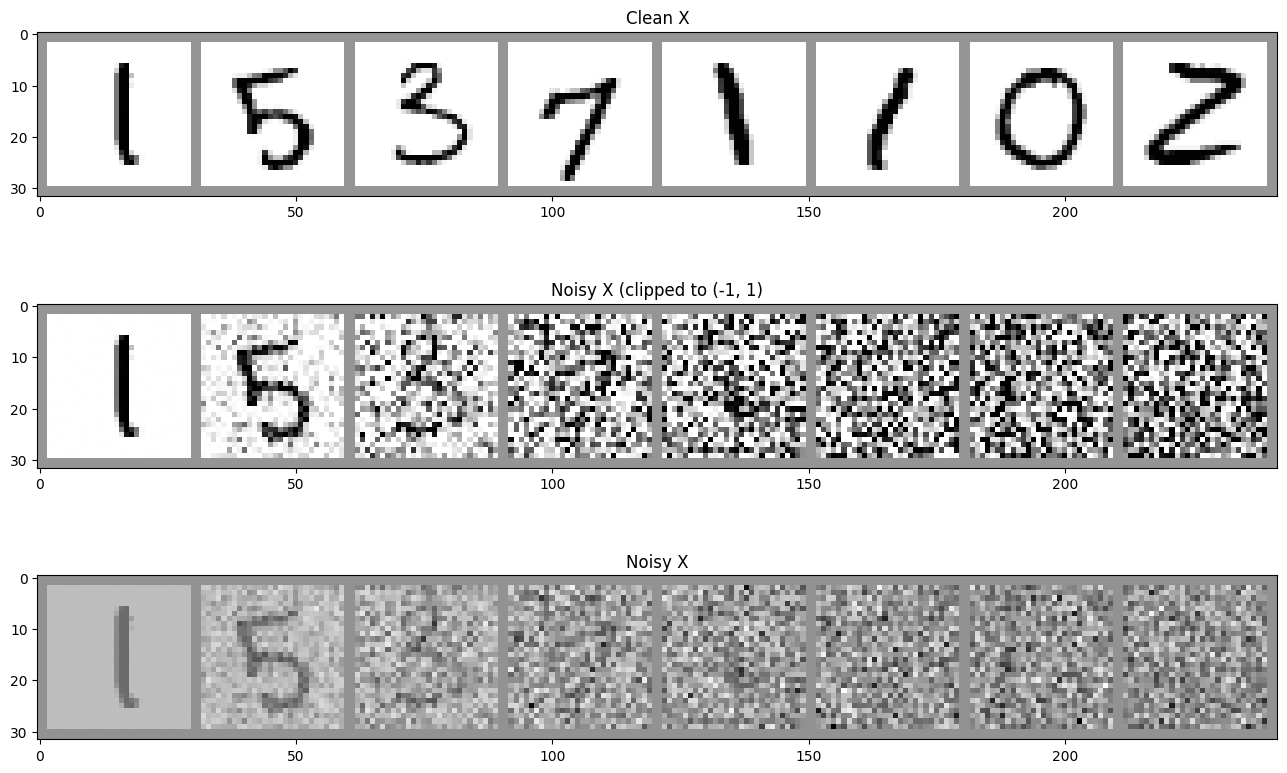

In [19]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

另一种动态变化：DDPM 版本添加了从高斯分布（均值为 0，标准差为 1，来自 `torch.randn`）中抽取的噪声，而不是我们在原始 `corrupt` 函数中使用的介于 0 和 1 之间的均匀噪声（来自 `torch.rand`）。一般来说，对训练数据进行归一化也是合理的。在另一个 notebook 中，你会在转换列表中看到 `Normalize(0.5, 0.5)`，它将图像数据从 (0, 1) 映射到 (-1, 1)，这对于我们来说已经“足够好”了。在这个 notebook 中我们没有这样做，但在上面的可视化单元格中添加了这一操作，以实现更精确的缩放和可视化。

### 训练目标

在我们的玩具示例中，我们让模型尝试预测去噪后的图像。在 DDPM 和许多其他扩散模型的实现中，模型预测的是用于腐蚀过程中的噪声（在缩放之前，因此是单位方差噪声）。在代码中，它看起来像这样：

```python
noise = torch.randn_like(xb) # << 注意：randn 而不是 rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # 以噪声作为目标
```

你可能会认为预测噪声（从中我们可以推导出去噪后图像的样子）等同于直接预测去噪后的图像。那么为什么选择一种而不是另一种——仅仅是为了数学上的方便吗？

事实证明这里还有一个细微之处。我们在训练过程中计算不同（随机选择的）时间步的损失。这些不同的目标会导致这些损失的不同“隐式加权”，其中预测噪声会更关注低噪声水平。你可以选择更复杂的目标来改变这种“隐式损失加权”。或者，你选择一个噪声计划，使得更高噪声水平的例子更多。也许你让模型预测一个“速度”v，我们将其定义为图像和噪声的组合，且该组合依赖于噪声水平（参见“PROGRESSIVE DISTILLATION FOR FAST SAMPLING OF DIFFUSION MODELS”）。也许你让模型预测噪声，然后根据一些理论（参见“Perception Prioritized Training of Diffusion Models”）或基于实验（试图找出对模型最有信息量的噪声水平，参见“Elucidating the Design Space of Diffusion-Based Generative Models”）来调整损失，使其取决于噪声量。简而言之：选择目标会对模型性能产生影响，并且关于“最佳”选项的研究仍在进行中。

目前，预测噪声（在某些地方你会看到 epsilon 或 eps）是首选方法，但随着时间的推移，我们可能会在库中看到其他目标的支持，并在不同情况下使用。

<br>

# 为什么预测噪声比预测去噪之后的图像可能效果更好？

### 1. **噪声预测 vs. 图像预测的目标差异**
- **预测噪声的目标**：模型的输出是添加到图像上的噪声 ($\epsilon$)。损失函数的目标是让模型尽可能准确地预测噪声本身。
- **预测图像的目标**：模型的输出是去噪后的图像 ($x_0$)。损失函数的目标是让模型尽可能恢复原始干净图像。

两者的目标不同，导致在训练过程中对不同噪声水平的样本的关注程度也不同。

---

### 2. **隐式加权的来源：损失的梯度大小**
在扩散模型中，噪声水平（通常用时间步 $t$ 表示）会影响输入数据的分布和损失函数的梯度大小：
- 高噪声水平：输入图像被高度腐蚀，几乎是随机噪声。
- 低噪声水平：输入图像接近于原始图像，噪声较少。

#### **预测图像时的隐式加权**
当模型预测的是去噪后的图像 ($\hat{x}_0$)，损失函数通常是均方误差 (MSE):
$$
\text{Loss} = \| \hat{x}_0 - x_0 \|^2
$$
在高噪声水平下：
- 图像几乎是随机噪声，$\hat{x}_0$ 和 $x_0$ 之间的差异很大。
- 损失值较大，但梯度的方向可能不准确，因为高噪声水平下的图像信息已经丢失，模型难以学习有效的表示。
在低噪声水平下：
- 图像接近真实图像，$\hat{x}_0$ 和 $x_0$ 之间的差异较小。
- 损失值较小，但梯度的方向更准确，模型可以更有效地学习。
**结果**：预测图像的损失函数对所有噪声水平的样本给予了相同的权重，但高噪声水平的样本可能提供了更多的噪声梯度，导致模型训练不够专注于低噪声样本。

#### **预测噪声时的隐式加权**
当模型预测的是噪声 ($\hat{\epsilon}$)，损失函数变为：
$$
\text{Loss} = \| \hat{\epsilon} - \epsilon \|^2
$$
在高噪声水平下：
- 输入图像被高度腐蚀，$\hat{\epsilon}$ 和 $\epsilon$ 之间的差异可能很大。
- 但由于输入接近随机噪声，预测噪声的任务变得更加困难，模型的梯度贡献较小。
在低噪声水平下：
- 输入图像接近真实图像，$\hat{\epsilon}$ 和 $\epsilon$ 之间的差异较小。
- 模型可以更准确地预测噪声，梯度贡献更大。
**结果**：预测噪声的损失函数对低噪声水平的样本给予了更高的隐式权重，因为这些样本的梯度方向更加准确，模型更容易学习。

---

### 3. **数学上的解释：损失的加权公式**
扩散模型的噪声调度器 (noise scheduler) 会对不同噪声水平的样本施加不同的权重。假设噪声水平由 $\sigma_t$ 表示，噪声调度器的作用是生成带有噪声的样本：
$$
\tilde{x} = \sqrt{1 - \sigma_t^2} \cdot x_0 + \sigma_t \cdot \epsilon
$$
在预测噪声的情况下，损失函数可以写为：
$$
\text{Loss} = \mathbb{E}_t \left[ w(t) \cdot \| \hat{\epsilon} - \epsilon \|^2 \right]
$$
其中 $w(t)$ 是噪声水平 $\sigma_t$ 的权重。通常，$w(t)$ 的值会随着 $\sigma_t$ (噪声水平) 的增大而减小，这意味着更高噪声水平的样本对总损失的贡献较小。

这种加权机制使得预测噪声的模型更关注低噪声水平的样本。

---

### 4. **直观理解：低噪声水平为何更重要**
低噪声水平的样本对于生成高质量图像至关重要，因为：
- 低噪声水平的样本更接近真实图像，包含更多有用的图像信息。
- 高噪声水平的样本接近随机噪声，信息量较少，对最终生成的图像贡献较小。

通过预测噪声的方法，模型在训练过程中会更专注于低噪声水平的样本，从而在生成阶段更容易还原高质量的图像。

---

### 5. **总结：逻辑链条**
- **预测噪声的损失函数**：对低噪声水平的样本给予更高的隐式权重。
- **预测图像的损失函数**：对所有噪声水平的样本给予相同权重。
- **训练目标的选择**：预测噪声的方法更关注低噪声水平的样本，而这些样本对生成高质量图像至关重要，因此预测噪声的方法通常效果更好。

这种隐式加权机制是预测噪声优于预测图像的核心原因之一。

<br>

### 时间步长调节（Timestep Conditioning）

UNet2DModel 同时接收 x 和 timestep 作为输入。后者会被转化为一个嵌入向量（embedding），并在多个位置馈送到模型中。

这一理论的依据是，通过给模型提供噪声水平的信息，它可以更好地完成任务。虽然可以在不使用此时间步长调节的情况下训练模型，但在某些情况下，它确实有助于提升性能，并且在大多数实现中都包含这一机制，至少在当前的文献中是如此。

### 采样

给定一个估计噪声输入中噪声的模型（或预测去噪版本），我们如何生成新的图像？

我们可以输入纯噪声，并希望模型在一步中预测出一个好的图像作为去噪版本。然而，正如我们在上面的实验中看到的，这通常效果不佳。因此，相反，我们根据模型的预测采取多个较小的步骤，每次迭代逐步去除一部分噪声。

我们如何采取这些步骤取决于所使用的采样方法。我们不会深入探讨理论，但一些关键的设计问题包括：
- 你应该采取多大的步长？换句话说，你应该遵循什么样的“噪声计划”？
- 你是否仅使用模型当前的预测来指导更新步骤（如 DDPM、DDIM 和许多其他方法）？你是否评估模型多次以估计高阶梯度，从而实现更大、更准确的步长（高阶方法和一些离散的 ODE 求解器）？或者你是否保留过去的预测历史，以更好地指导当前的更新步骤（线性多步法和祖先采样器）？
- 你是否添加额外的噪声（有时称为 churn）以增加采样过程的随机性，还是保持完全确定性？许多采样器通过参数（例如 DDIM 采样器中的 'eta'）来控制这一点，以便用户可以选择。

扩散模型的采样方法研究正在迅速发展，并且不断提出越来越多的方法，以在更少的步骤中找到良好的解决方案。勇敢而好奇的人可能会对浏览 diffusers 库中不同实现的代码 [此处](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers) 或查阅 [文档](https://huggingface.co/docs/diffusers/api/schedulers/overview) 感兴趣，文档中通常会链接到相关的论文。

## 结论

希望这能成为一种从稍微不同角度看待扩散模型的有益方式。

本笔记本由 Jonathan Whitaker 为这个 Hugging Face 课程编写，并且与他自己的课程中包含的一个[版本](https://johnowhitaker.github.io/tglcourse/dm1.html)重叠，该课程名为 'The Generative Landscape'。如果你希望看到这个基本例子通过添加噪声和类别条件进行扩展，可以查看该课程。问题或错误可以通过 GitHub issues 或 Discord 反馈。你也可以通过 Twitter [@johnowhitaker](https://twitter.com/johnowhitaker) 联系他。